# Prueba el modelo

Este notebook esta diseño, para jugar con el modelo entrenado 

In [ ]:
#Para correr bien este notebook, debemos bajar un modelo de huggingface

#pip install huggingface_hub[hf_xet]

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.engine.results import Results
from transformers import pipeline
from PIL import Image
from typing import List, Union, Tuple, Optional
import torch

class ObjectDetector:
    model: YOLO
    detections: Optional[Results]
    raw_img: Optional[np.ndarray]
    crops: List[np.ndarray]
    ocr_results: List[str]
    ocr_pipe: Optional[object]

    def __init__(self, model_name: str) -> None:
        """Carga el modelo YOLO y prepara atributos."""
        self.model: YOLO = YOLO(model_name)
        self.detections: Optional[Results] = None
        self.raw_img: Optional[np.ndarray] = None
        self.crops: List[np.ndarray] = []
        self.ocr_results: List[str] = []
        self.ocr_pipe: Optional[object] = None

    def predict(self, image: Union[str, np.ndarray]) -> Results:
        """
        Realiza detección y guarda la imagen original en alta resolución en `self.raw_img`.
        """
        # 1) Cargar imagen sin modificar
        if isinstance(image, str):
            bgr = cv2.imread(image)
            if bgr is None:
                raise FileNotFoundError(f"No se pudo leer la imagen: {image}")
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        else:
            bgr = image.copy()
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        self.raw_img = rgb  # guardamos la imagen original :contentReference[oaicite:0]{index=0}

        # 2) Inferencia sobre la misma imagen (YOLO letterbox internamente)
        self.detections = self.model.predict(rgb, verbose=False)[0]
        return self.detections

    def extract_crops(self, keep: float = 0.0) -> List[np.ndarray]:
        """
        Extrae recortes de `self.raw_img` usando las cajas en `self.detections`,
        preservando la calidad original.
        """
        if self.detections is None or self.raw_img is None:
            raise RuntimeError("Ejecute primero predict() antes de extract_crops().")
           
           

        self.crops.clear()
    
        for box, conf in zip(
            self.detections.boxes.xyxy.cpu().numpy(),
            self.detections.boxes.conf.cpu().numpy()
        ):
            if conf < keep:
                continue
            x1, y1, x2, y2 = box.astype(int)
            crop = self.raw_img[y1:y2, x1:x2]  # recorte directo de original
            self.crops.append(crop)

        return self.crops

    def init_ocr(self, ocr_model_name: str = "microsoft/trocr-base-printed") -> None:
        """Inicializa el pipeline de OCR detectando el mejor dispositivo."""
        device = "mps" if torch.backends.mps.is_available() \
                 else 0 if torch.cuda.is_available() else -1
        self.ocr_pipe = pipeline("image-to-text", model=ocr_model_name, device=device)

    def ocr_plate(self) -> List[str]:
        """Aplica OCR sobre cada recorte en `self.crops`."""
        if not self.crops:
            raise RuntimeError("Ejecute extract_crops() antes de ocr_plate().")
        if self.ocr_pipe is None:
            self.init_ocr()
        self.ocr_results = [
            self.ocr_pipe(Image.fromarray(c))[0]["generated_text"].strip()
            for c in self.crops
        ]
        return self.ocr_results

    def show_image(self, mode: str = 'detections',
                   figsize: Tuple[float, float] = (8, 6)) -> None:
        """
        Muestra inline (notebook) la imagen con cajas+etiquetas o cada crop,
        usando matplotlib para evitar ventanas externas.
        """
        if mode == 'detections':
            if self.detections is None or self.raw_img is None:
                raise RuntimeError("Ejecute predict() antes de show_image().")
            img = self.raw_img.copy()
            for box, cls_id, conf in zip(
                self.detections.boxes.xyxy.cpu().numpy().astype(int),
                self.detections.boxes.cls.cpu().numpy().astype(int),
                self.detections.boxes.conf.cpu().numpy()
            ):
                x1, y1, x2, y2 = box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                label = f"{self.model.names[cls_id]} {conf:.2f}"
                font, fs, th = cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
                (w, h), _ = cv2.getTextSize(label, font, fs, th)
                ty = y1 - 5 if y1 - 5 > h else y1 + h + 5
                cv2.rectangle(img, (x1, ty-h), (x1+w, ty+2), (0,255,0), cv2.FILLED)
                cv2.putText(img, label, (x1, ty), font, fs, (0,0,0), th, cv2.LINE_AA)
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        elif mode == 'crops':
            if not self.crops:
                raise RuntimeError("Ejecute extract_crops() antes de show_image().")
            for crop in self.crops:
                plt.figure(figsize=figsize)
                plt.imshow(crop)
                plt.axis('off')
                plt.show()
        else:
            raise ValueError("Modo desconocido. Use 'detections' o 'crops'.")
        
class  ProbarModelo: # Clase para facilitar el test del modelo
    def __init__(self, model_path: str):
        self.det = ObjectDetector(model_path)
    def ejecutar(self, car_path):
        results = self.det.predict(car_path) # Realizamos la predicción
        self.det.show_image("detections")    # muestrar detecciones inline
        self.det.extract_crops(keep=0.5)
        try:
            self.det.show_image("crops")
            texts = self.det.ocr_plate() 
            print("El texto de la placa es:")# aplicar OCR en MPS/GPU/CPU
            print(texts)
        except RuntimeError as e:
            print(f"No hay placa disponible")

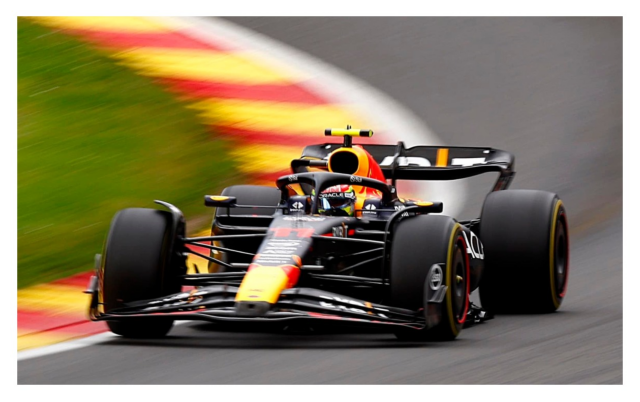

No hay placa disponible


In [9]:
PruebaYolo10S = ProbarModelo('./TraineModels/YOLO10S.pt')
PruebaYolo10S.ejecutar('./Imagenes/carroF1.jpg') # Solo Ir cambiando la ruta de la imagen

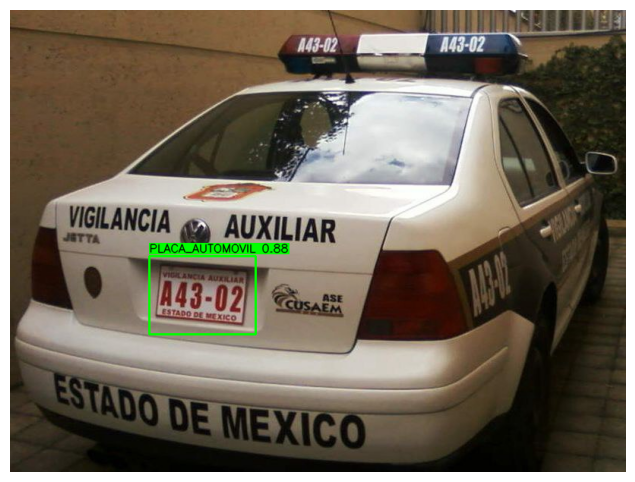

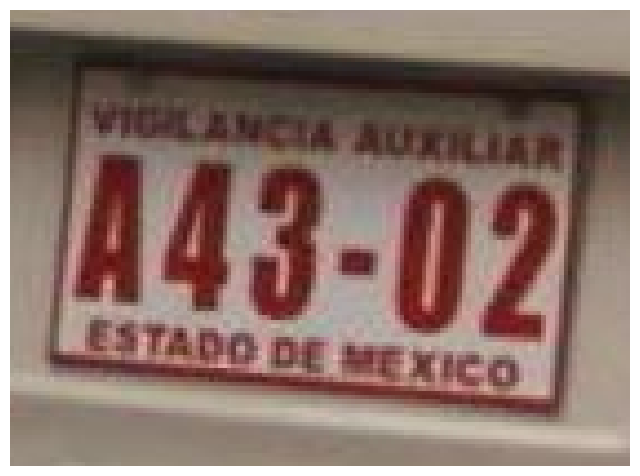

El texto de la placa es:
['A43-02']


In [11]:
PruebaYolo10S.ejecutar('./Imagenes/carro.jpg') # Solo Ir cambiando la ruta de la imagen